## Gaussian Mixture Models

#### Used Same Pitching DataPrep as GS

Data Prep Section

In [25]:
# getting things started
%matplotlib inline

import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [26]:
pitching = pd.read_pickle("./analysisdata/pitching.pkl")
pitchingSv = pitching

In [27]:
pitching = pitching[pitching.ERA < 9]
pitching = pitching[pitching.yearID > 2007]

In [28]:
#Save pitcher IDs for potential post clustering analysis
pitchIDs = pitching[['yearID', 'playerID', 'salary', 'adjSalary2']]
#print(pitchIDs)

#One Hot Encoding for throws
tmp_df = pd.get_dummies(pitching.throws,prefix='throws')
pitchingSC = pd.concat((pitching,tmp_df),axis=1) # add back into the dataframe

#Drop Throws after one-hot encoding
#Drop Attributes no longer needed (MinSalaries, adjMinSalaries, adjSalary, playerID, bats, stint
pitchingSC = pitchingSC.drop(['height', 'weight', 'salary', 'MinSalaries', 'adjMinSalaries', 'adjSalary', 'adjSalary2', 'playerID', 'bats', 'stint', 'throws'], axis=1)
colNamesPSC = pitchingSC.columns

#Scale pitchingSC
scaler = StandardScaler()
pitchingSCScaled = scaler.fit_transform(pitchingSC)
pitchingSCScaled = pd.DataFrame(pitchingSCScaled, columns=colNamesPSC)

#print(pitchingSC.head())
#print(pitchingSC.info())
#print(pitchingSC.shape)
#print(pitchingSCScaled.head())
#print(pitchingSCScaled.info())

In [29]:
X1 = pitchingSC
#pitchingSC.describe()
X1 = pitchingSC.values
print(type(X1))

<class 'numpy.ndarray'>
Wall time: 1.5 ms


In [102]:
#plt.plot(X1)

## Gaussian Mixture Models

In [89]:
%%time
# this code has been manipulated from the source available on sklearn's website documentation
import itertools

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

X = X1

lowest_bic = np.infty
bic = []
n_components_range = range(10,20)
cv_types = ['spherical','tied', 'diag', 'full']
in_parm_types = ['random','kmeans']
for in_parm_type in in_parm_types:
    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a mixture of Gaussians with EM
            gmm = mixture.GaussianMixture(n_components=n_components, covariance_type=cv_type, init_params=in_parm_type, max_iter=200, random_state=42)
            gmm.fit(X)
            bic.append(gmm.bic(X))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm

Wall time: 1min 47s


In [90]:
print(best_gmm)
#print(bic)
print('\n Lowest BIC: %.2f' % lowest_bic)

GaussianMixture(covariance_type='full', init_params='random', max_iter=200,
        means_init=None, n_components=15, n_init=1, precisions_init=None,
        random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

 Lowest BIC: 247569.46


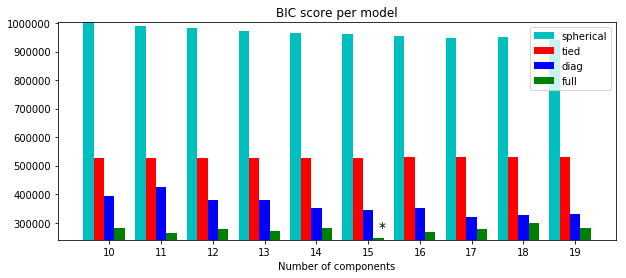

In [93]:
# this code has been manipulated from the source available on sklearn's website documentation
# plot the BIC
bic = np.array(bic)
color_iter = itertools.cycle(['c', 'r', 'b', 'g', 'k', 'm', 'y'])
clf = best_gmm
bars = []

plt.figure(figsize=(10,4))
spl = plt.subplot(1,1,1)
# Plot the BIC scores
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')

xpos = np.min(n_components_range)-0.4 + np.mod(bic.argmin(), len(n_components_range)) +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

plt.show()

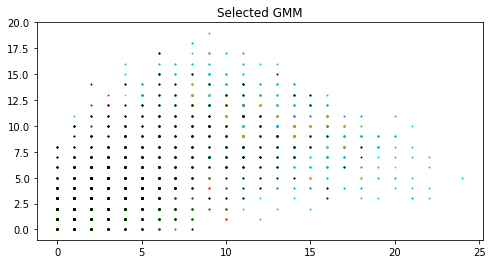

In [94]:
# this code has been manipulated from the source available on sklearn's website documentation
# Plot the winner
plt.figure(figsize=(8,4))
splot = plt.subplot(1,1,1)
Y_ = clf.predict(X)
for i, (mean, covar, color) in enumerate(zip(clf.means_, clf.covariances_,
                                             color_iter)):
    if len(covar.shape)<2:
        tmp = np.zeros((2,2))
        np.fill_diagonal(tmp,covar)
        covar = tmp
    elif covar.shape[0] != covar.shape[1]:
        covar = np.diag(covar)
        
    v, w = linalg.eigh(covar)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180 * angle / np.pi  # convert to degrees
    v *= 4
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180 + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)


plt.title('Selected GMM')
plt.show()